In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv("training.csv")
df_deploy = pd.read_csv("deploy.csv")

df_train.head(2)

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77


In [2]:
# removing records with missing data from the training set
df_train = df_train[pd.notnull(df_train['SpinRate'])]
df_train.shape

(9994, 5)

In [3]:
# how many hits?
df_train['InPlay'].sum()

2716

In [4]:
### seperate the predictors and response variables
x = df_train.drop('InPlay', axis=1)

# preprocessing the inputs to the same scale
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.to_numpy())
x_scaled = pd.DataFrame(x_scaled, columns=['Velo', 'SpinRate',' HorzBreak', 'InducedVertBreak'])

y = df_train['InPlay']

# training and test sets - keeping the hit ratio the same in both
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, 
                                                    test_size=0.3, 
                                                    random_state=4, 
                                                    stratify=y
                                                   )

Confusion Matrix: 
 [[1352  832]
 [ 440  375]] 

Other Metrics: 
               precision    recall  f1-score   support

           0       0.75      0.62      0.68      2184
           1       0.31      0.46      0.37       815

    accuracy                           0.58      2999
   macro avg       0.53      0.54      0.53      2999
weighted avg       0.63      0.58      0.60      2999
 



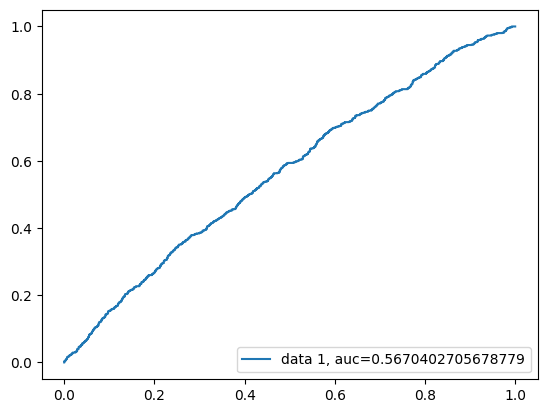

In [13]:
# training logistic regression
logreg = linear_model.LogisticRegression(random_state=17,
                                        class_weight='balanced'
                                        )
logreg.fit(x_train, y_train)

# predicting outcomes
logreg_y_pred = logreg.predict(x_test)          # predicted class
logreg_predProb = logreg.predict_proba(x_test)  # class probabilities

print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, logreg_y_pred), "\n")
print("Other Metrics: \n", metrics.classification_report(y_test, logreg_y_pred), "\n")

# ROC CURVE
y_pred_proba = logreg_predProb[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# RANDOM FOREST MODEL

Accuracy: 0.7105701900633544
Confusion Matrix: 
 [[2084  100]
 [ 768   47]] 

Other Metrics: 
               precision    recall  f1-score   support

           0       0.73      0.95      0.83      2184
           1       0.32      0.06      0.10       815

    accuracy                           0.71      2999
   macro avg       0.53      0.51      0.46      2999
weighted avg       0.62      0.71      0.63      2999
 



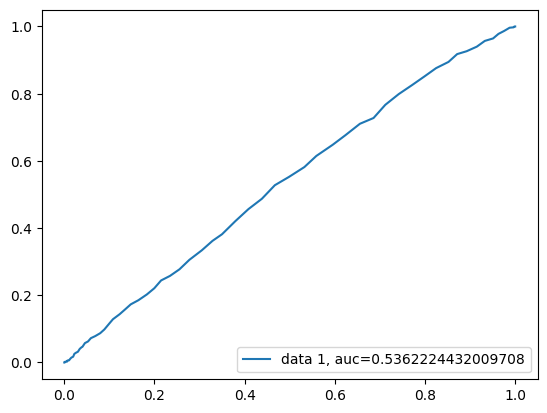

In [14]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced',random_state=17)
rf.fit(x_train, y_train)
rf_y_pred = rf.predict(x_test)
rf_y_predProb = rf.predict_proba(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, rf_y_pred))
print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, rf_y_pred), "\n")
print("Other Metrics: \n", metrics.classification_report(y_test, rf_y_pred), "\n")
feature_imp = pd.Series(rf.feature_importances_,index=df_deploy.columns).sort_values(ascending=False)
feature_imp

# ROC CURVE
y_pred_proba = rf_y_predProb[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# STOCHASTIC GRAD. BOOST MODEL

Accuracy: 0.6875625208402801
Confusion Matrix: 
 [[1922  262]
 [ 675  140]] 

Other Metrics: 
               precision    recall  f1-score   support

           0       0.74      0.88      0.80      2184
           1       0.35      0.17      0.23       815

    accuracy                           0.69      2999
   macro avg       0.54      0.53      0.52      2999
weighted avg       0.63      0.69      0.65      2999
 



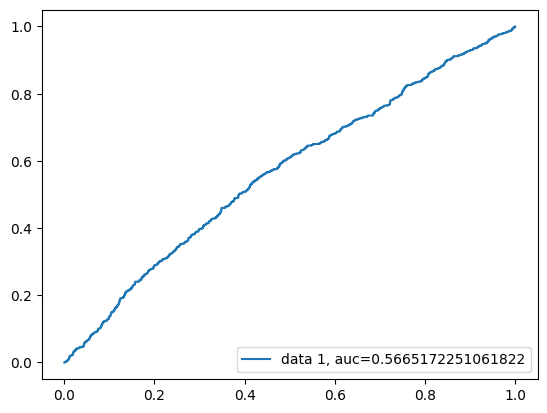

In [15]:
sgd = linear_model.SGDClassifier(max_iter = 1000,loss='log_loss',penalty = "elasticnet", class_weight='balanced', random_state=34)
sgd.fit(x_train, y_train)
sgd_y_pred = sgd.predict(x_test)
sgd_y_predProb = sgd.predict_proba(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, sgd_y_pred))
print("Confusion Matrix: \n", metrics.confusion_matrix(y_test, sgd_y_pred), "\n")
print("Other Metrics: \n", metrics.classification_report(y_test, sgd_y_pred), "\n")

# ROC CURVE
y_pred_proba = sgd_y_predProb[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# PREDICTING DEPLOY DATA - USING LOGREG

In [16]:
# impute Spinrate average for NaNs
x = df_deploy.copy()
x = x.fillna(x.mean())

# preprocessing the inputs to the same scale
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.to_numpy())
x_scaled = pd.DataFrame(x_scaled, columns=['Velo', 'SpinRate',' HorzBreak', 'InducedVertBreak'])

# predict
deploy_pred = logreg.predict(x_scaled)          # predicted class
deploy_predProb = logreg.predict_proba(x_scaled)  # class probabilities

In [ ]:
predictions = pd.DataFrame({"hitProb":deploy_predProb[::,1],
                           "hitPredicted":deploy_pred})
predictions.to_csv("predictions_JohnBrzezinski.csv")

# HIT PROBABILITIES - SINGLE INPUTS BINNED

In [17]:
t = df_train.copy()
t['bin'] = pd.qcut(t['Velo'], q=15)
idx = pd.IntervalIndex(t['bin'])
t['low'] = idx.left
t['high'] = idx.right
t['velo range'] = t['low'].round(2).astype(str) + "-" + t['high'].round(2).astype(str)
df_bins_grouped = t[['velo range', 'Velo', 'InPlay']].groupby('velo range').agg({'Velo':'count',
                                                                                'InPlay':'sum'})
df_bins_grouped = df_bins_grouped.reset_index()
df_bins_grouped['prob'] =  df_bins_grouped['InPlay'] / df_bins_grouped['Velo']
df_bins_grouped

,velo range,Velo,InPlay,prob
0,59.76-90.08,670,215,0.320896
1,90.08-91.38,667,204,0.305847
2,91.38-92.14,663,200,0.301659
3,92.14-92.67,679,186,0.273932
4,92.67-93.11,653,183,0.280245
5,93.11-93.52,676,176,0.260355
6,93.52-93.9,661,194,0.293495
7,93.9-94.28,664,184,0.277108
8,94.28-94.64,666,175,0.262763
9,94.64-95.07,672,184,0.273810


<AxesSubplot:xlabel='velo range', ylabel='prob'>

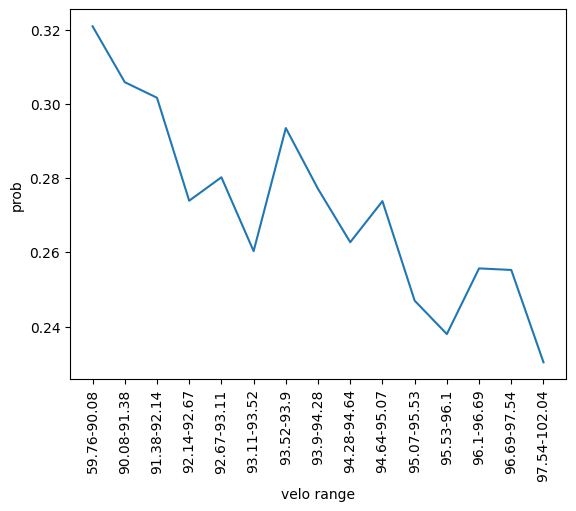

In [18]:
plt.xticks(rotation=90)
sns.lineplot(data=df_bins_grouped, x = 'velo range', y='prob')

In [19]:
t = df_train.copy()
t['bin'] = pd.qcut(t['HorzBreak'], q=15)
idx = pd.IntervalIndex(t['bin'])
t['low'] = idx.left
t['high'] = idx.right
t['HorzBreak range'] = t['low'].round(2).astype(str) + "-" + t['high'].round(2).astype(str)
df_bins_grouped = t[['HorzBreak range', 'HorzBreak', 'InPlay']].groupby('HorzBreak range').agg({'HorzBreak':'count',
                                                                                'InPlay':'sum'})
df_bins_grouped = df_bins_grouped.reset_index()
df_bins_grouped['hit prob'] =  df_bins_grouped['InPlay'] / df_bins_grouped['HorzBreak']
df_bins_grouped = df_bins_grouped.reindex([0,7,8,9,10,11,12,13,14,1,2,3,4,5,6])
df_bins_grouped

,HorzBreak range,HorzBreak,InPlay,hit prob
0,-6.27-2.03,667,167,0.250375
7,2.03-3.76,666,159,0.238739
8,3.76-4.95,677,158,0.233383
9,4.95-5.99,655,152,0.232061
10,5.99-6.96,672,152,0.226190
11,6.96-7.96,668,155,0.232036
12,7.96-8.92,665,158,0.237594
13,8.92-9.98,660,167,0.253030
14,9.98-11.05,668,174,0.260479
1,11.05-12.18,671,184,0.274218


<AxesSubplot:xlabel='HorzBreak range', ylabel='hit prob'>

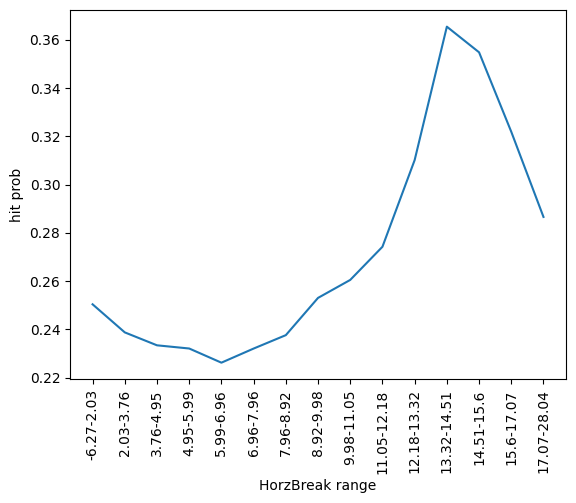

In [20]:
plt.xticks(rotation=90)
sns.lineplot(data=df_bins_grouped, x = 'HorzBreak range', y='hit prob')

In [21]:
t = df_train.copy()
t['bin'] = pd.qcut(t['InducedVertBreak'], q=15)
idx = pd.IntervalIndex(t['bin'])
t['low'] = idx.left
t['high'] = idx.right
t['InducedVertBreak range'] = t['low'].round(2).astype(str) + "-" + t['high'].round(2).astype(str)
#df_bins_grouped = t[['velo range', 'Velo']].groupby('velo range').mean().reset_index()
df_bins_grouped = t[['InducedVertBreak range', 'InducedVertBreak', 'InPlay']].groupby('InducedVertBreak range').agg({'InducedVertBreak':'count',
                                                                                'InPlay':'sum'})
df_bins_grouped = df_bins_grouped.reset_index()
df_bins_grouped['prob'] =  df_bins_grouped['InPlay'] / df_bins_grouped['InducedVertBreak']
df_bins_grouped= df_bins_grouped.reindex([0,13,14,2,3,4,5,6,7,8,9,10,11,12])

<AxesSubplot:xlabel='InducedVertBreak range', ylabel='prob'>

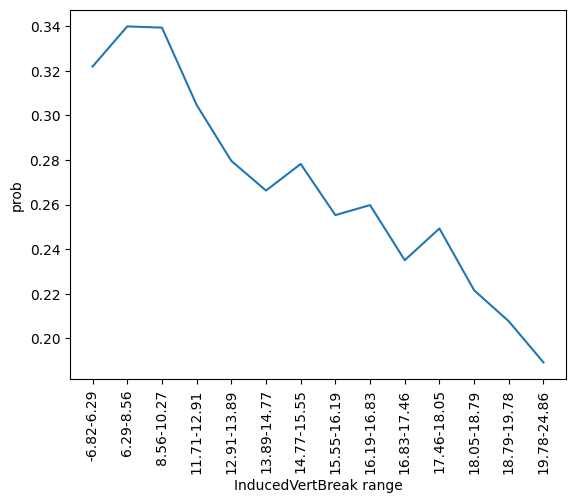

In [22]:
plt.xticks(rotation=90)
sns.lineplot(data=df_bins_grouped, x = 'InducedVertBreak range', y='prob')

In [23]:
t = df_train.copy()
t['bin'] = pd.qcut(t['SpinRate'], q=15)
idx = pd.IntervalIndex(t['bin'])
t['low'] = idx.left
t['high'] = idx.right
t['SpinRate range'] = t['low'].round(2).astype(str) + "-" + t['high'].round(2).astype(str)
#df_bins_grouped = t[['velo range', 'Velo']].groupby('velo range').mean().reset_index()
df_bins_grouped = t[['SpinRate range', 'SpinRate', 'InPlay']].groupby('SpinRate range').agg({'SpinRate':'count',
                                                                                'InPlay':'sum'})
df_bins_grouped = df_bins_grouped.reset_index()
df_bins_grouped['prob'] =  df_bins_grouped['InPlay'] / df_bins_grouped['SpinRate']
df_bins_grouped = df_bins_grouped.reindex([14,0,1,2,3,4,5,6,7,8,9,10,11,12,13,15])
df_bins_grouped

,SpinRate range,SpinRate,InPlay,prob
14,770.0-1953.0,671.0,231.0,0.344262
0,1953.0-2026.0,668.0,217.0,0.324850
1,2026.0-2077.0,665.0,179.0,0.269173
2,2077.0-2117.0,675.0,198.0,0.293333
3,2117.0-2157.0,670.0,192.0,0.286567
4,2157.0-2190.0,659.0,181.0,0.274659
5,2190.0-2224.0,658.0,198.0,0.300912
6,2224.0-2256.0,667.0,175.0,0.262369
7,2256.0-2287.0,674.0,180.0,0.267062
8,2287.0-2320.0,660.0,161.0,0.243939


<AxesSubplot:xlabel='SpinRate range', ylabel='prob'>

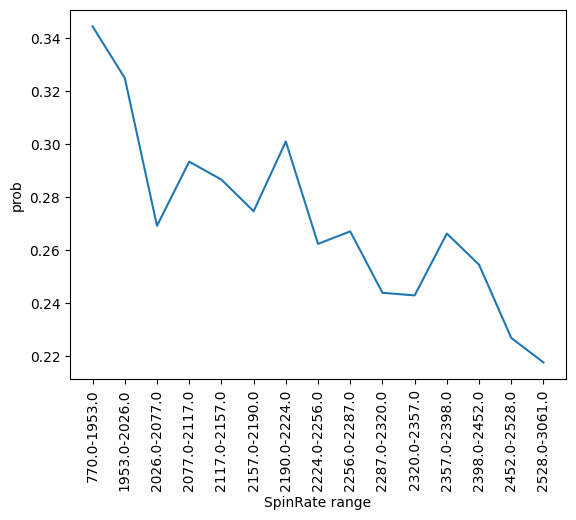

In [24]:
plt.xticks(rotation=90)
sns.lineplot(data=df_bins_grouped, x = 'SpinRate range', y='prob')

# EXPLORATORY GRAPHS - LOOKING FOR HIGH DENSITY POCKETS

In [31]:
test = df_train.copy()
test.head()

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77
2,0,90.48,2183.0,6.61,15.39
3,0,93.04,2279.0,9.33,14.57
4,0,95.17,2384.0,6.99,17.62


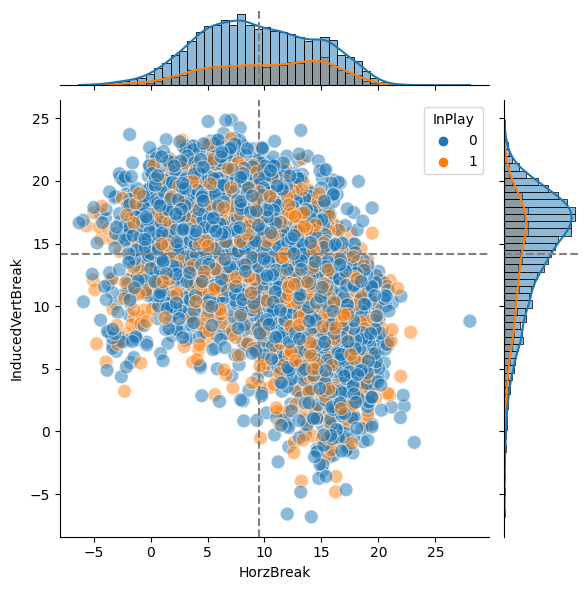

In [32]:
g = sns.JointGrid(data=test, x="HorzBreak", y="InducedVertBreak", hue='InPlay')
#g.plot(sns.scatterplot, sns.histplot)
g.plot_joint(sns.scatterplot, s=100, alpha=.5)
g.plot_marginals(sns.histplot, kde=True)
g.refline(x=test['HorzBreak'].mean(), y=test['InducedVertBreak'].mean())

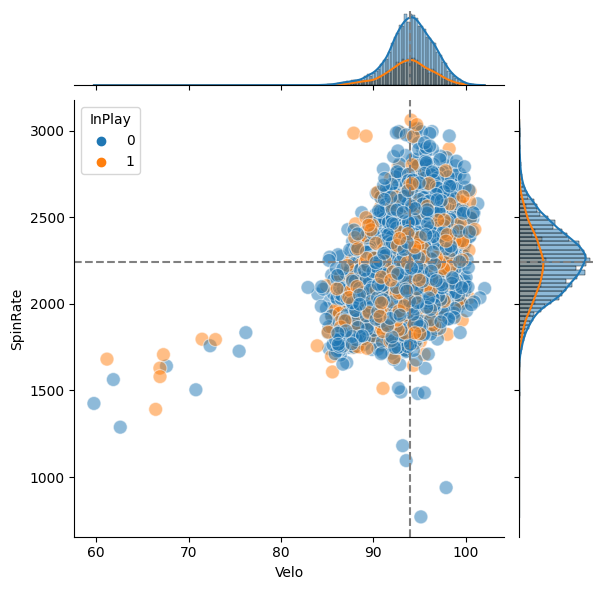

In [33]:
g = sns.JointGrid(data=test, x="Velo", y="SpinRate", hue='InPlay')
#g.plot(sns.scatterplot, sns.histplot)
g.plot_joint(sns.scatterplot, s=100, alpha=.5)
g.plot_marginals(sns.histplot, kde=True)
g.refline(x=test['Velo'].mean(), y=test['SpinRate'].mean())